In [160]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np 

import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
import umap
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from amlvae.models.VAE import VAE 
from amlvae.models.VQVAE import VQVAE 
from amlvae.models.pVAE import pVAE 
from amlvae.train.Trainer import Trainer

# auto reimport 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
expr_long = pd.read_csv('../../../aml_train.csv')
expr_long.head()

,id,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,9507c9d3-5021-49d9-b0e6-e04304077840,ENSG00000000003.15,TSPAN6,protein_coding,4,0,4,0.1130,0.0316,0.0279
1,9507c9d3-5021-49d9-b0e6-e04304077840,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000
2,9507c9d3-5021-49d9-b0e6-e04304077840,ENSG00000000419.13,DPM1,protein_coding,1127,7,1120,119.6758,33.4201,29.5103
3,9507c9d3-5021-49d9-b0e6-e04304077840,ENSG00000000457.14,SCYL3,protein_coding,726,373,812,13.5191,3.7753,3.3336
4,9507c9d3-5021-49d9-b0e6-e04304077840,ENSG00000000460.17,C1orf112,protein_coding,494,286,707,10.6058,2.9617,2.6152


: 

In [ ]:
class ExprProccessor(): 
    def __init__(self, expr_long, target='fpkm_uq_unstranded', norm='zscore_log2', top_genes=1000, idxs=None):
        
        self.target = target 
        expr = expr_long[['id', 'gene_name', target]].groupby(['id', 'gene_name']).mean()
        expr = expr.reset_index().pivot(index='id', columns='gene_name', values=target)

        if norm == 'zscore_log2':
            expr = np.log2(expr + 1)
            mu = expr.mean(axis=0)
            sd = expr.std(axis=0)
            self.transform_params = {'mu': mu, 'sd': sd, 'norm': norm}

            expr = (expr - mu) / (sd + 1e-8)

        else: 
            raise ValueError('norm not implemented')
        

        if idxs is None:
            self.idxs = np.argsort(expr.var(axis=0))[::-1][:top_genes]
        else: 
            self.idxs = idxs 

        self.expr = expr.iloc[:, self.idxs]

        self.gene_names = self.expr.columns

    def get_data(self):
        return self.expr.values
    
    def process_new(self, expr_long): 
        '''process a new dataset'''

        expr = expr_long[['id', 'gene_name', self.target]].groupby(['id', 'gene_name']).mean()
        expr = expr.reset_index().pivot(index='id', columns='gene_name', values=self.target)

        if self.transform_params['norm'] == 'zscore_log2':
            expr = np.log2(expr + 1)
            expr = (expr - self.transform_params['mu']) / (self.transform_params['sd'] + 1e-8)

        return expr.iloc[:, self.idxs].values

In [109]:
target_ = 'fpkm_uq_unstranded'
zscore = True 

# expr = expr[lambda x: x.gene_type == 'protein_coding']
expr = expr_long[['id', 'gene_name', target_]].groupby(['id', 'gene_name']).mean()
expr = expr.reset_index().pivot(index='id', columns='gene_name', values=target_)

if zscore: 
    expr = np.log2(expr + 1)
    mu = expr.mean(axis=0)
    sd = expr.std(axis=0)
    # zscore over each gene 
    expr = (expr - mu) / (sd + 1e-8)

expr.head()

gene_name,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3,hsa-mir-1253,hsa-mir-423,snoZ196
id,,,,,,,,,,,,,,,,,,,,,
001454b2-aff9-4659-85a6-73fb8092589a,0.040431,9.098619,-0.569588,-0.284079,-0.285545,-0.344347,-0.369727,0.953207,0.275714,1.643544,...,-0.219513,-0.044237,0.414079,-0.976598,0.0,-0.692584,0.315365,0.0,0.0,-0.192609
002cacd9-c03b-4526-a380-0701f41c4a9e,-1.646056,-0.125136,-0.569588,0.971361,1.397797,2.172239,-0.373360,-0.505177,-0.308137,-0.357898,...,0.064672,-0.044237,0.424822,0.386888,0.0,0.874448,-0.647057,0.0,0.0,-0.192609
006e5777-2603-4db7-a1d6-8c8085c5e3e5,-0.509202,-0.125136,-0.569588,-0.384045,-0.043686,0.072437,-0.737016,-0.365702,0.194290,-0.357898,...,-0.103372,-0.044237,0.883728,-0.511853,0.0,-0.053696,1.061889,0.0,0.0,-0.192609
00870f33-cab3-4c23-bd0d-8903a5a9789e,-0.274709,-0.125136,-0.569588,-0.703183,-1.254253,-0.344347,-0.471206,-0.654593,-0.678947,-0.357898,...,-0.544182,-0.044237,-1.879271,1.109950,0.0,2.134343,-0.752527,0.0,0.0,-0.192609
00b535f6-064a-4dcf-ab14-387a54eedeee,0.099740,-0.125136,1.272093,-0.724498,2.627626,-0.344347,-0.593489,-0.884581,-0.459046,-0.357898,...,-0.724162,-0.044237,-1.712890,1.832509,0.0,-1.447697,-3.683451,0.0,0.0,10.780340


In [88]:
wgcna = pd.read_csv('../../../aml_train_wgcna_modules.csv')
wgcna = wgcna.merge(expr_long[['gene_id', 'gene_name']].drop_duplicates(), on='gene_id')
wgcna.head()

,param,gene_id,colors,labels,module,gene_name
0,twok_4p_v4,ENSG00000239839.7,yellow,4,Mod4 (yellow),DEFA3
1,twok_4p_v4,ENSG00000129824.16,grey,0,Mod0 (grey),RPS4Y1
2,twok_4p_v4,ENSG00000224739.2,blue,2,Mod2 (blue),AC016735.1
3,twok_4p_v4,ENSG00000012223.13,yellow,4,Mod4 (yellow),LTF
4,twok_4p_v4,ENSG00000164821.5,yellow,4,Mod4 (yellow),DEFA4


In [91]:
wgcna.groupby('module').count()

,param,gene_id,colors,labels,gene_name
module,,,,,
Mod0 (grey),365,365,365,365,365
Mod1 (turquoise),497,497,497,497,497
Mod2 (blue),337,337,337,337,337
Mod3 (brown),212,212,212,212,212
Mod4 (yellow),204,204,204,204,204
Mod5 (green),160,160,160,160,160
Mod6 (red),100,100,100,100,100
Mod7 (black),76,76,76,76,76
Mod8 (pink),49,49,49,49,49


In [110]:
X = torch.tensor(expr.values, dtype=torch.float32)
#X = X[:, sd.values > np.quantile(sd, 0.95)]
wgcna0_idxs = [i for i,g in enumerate(expr.columns) if (g in wgcna[lambda x: x.labels == 0].gene_name.values)]
X = X[:, wgcna0_idxs]
X.size()

torch.Size([511, 362])

In [117]:
num_samples = X.size(0)
num_train = int(0.99 * num_samples)
train_data, val_data = torch.utils.data.random_split(X, [num_train, num_samples - num_train])

X_train = train_data.dataset[train_data.indices]
X_val = val_data.dataset[val_data.indices]

model_kwargs = {'input_dim': X.size(1), 'hidden_dims': [512, 256], 'latent_dim': 64, 'norm':'layer'}

model = VAE(**model_kwargs)
#model = pVAE(**model_kwargs)
#model = VQVAE(num_embeddings=256, **model_kwargs)
trainer = Trainer(model)

trainer.train(X_train=X_train, X_val=X_val, epochs=250, lr=1e-4, beta=1)

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


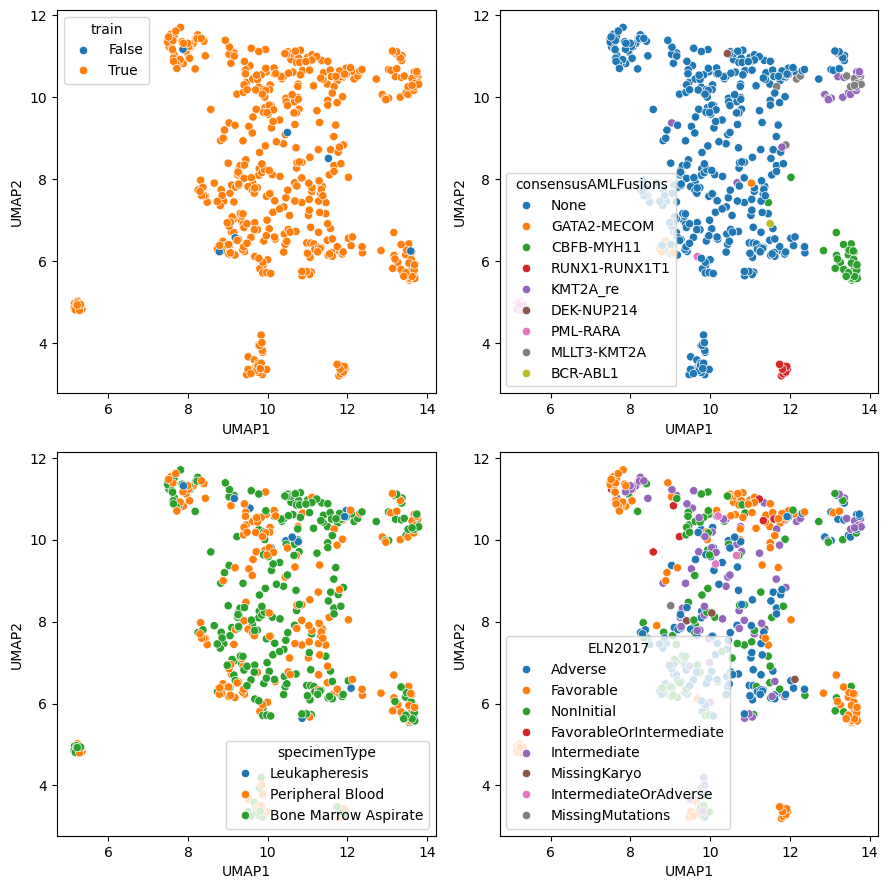

In [222]:
clin = pd.read_csv('../../../beataml_clinical_for_inputs.csv')
clin.consensusAMLFusions = clin.consensusAMLFusions.fillna('None')
model = trainer.get_best_model()
z = model.encode(X)[0].detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=25, n_components=2, metric='euclidean', min_dist=0.1)
u = reducer.fit_transform(z)

train_mask = np.array([i in train_data.indices for i in range(num_samples)])
ures = pd.DataFrame(u, columns=['UMAP1', 'UMAP2']).assign(train=train_mask, gdc_id=expr.index)
ures = ures.merge(clin, on='gdc_id')


f, axes = plt.subplots(2,2, figsize=(9,9))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='train', alpha=1., ax=axes[0,0])
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensusAMLFusions', alpha=1., ax=axes[0,1])
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='specimenType', alpha=1., ax=axes[1,0])
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='ELN2017', alpha=1., ax=axes[1,1])
plt.tight_layout()
plt.show()

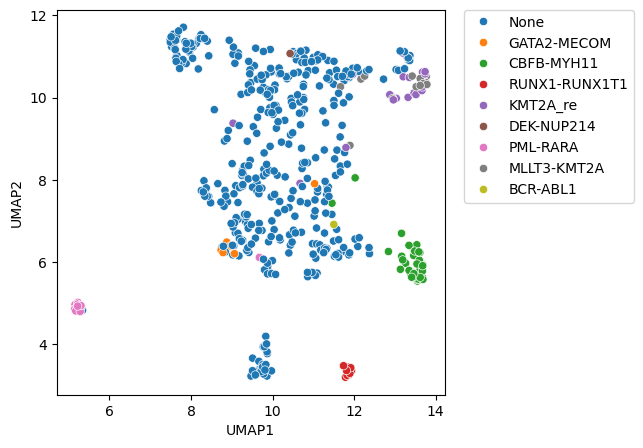

In [240]:
f, axes = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensusAMLFusions', alpha=1., ax=axes)
# move legend to the outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

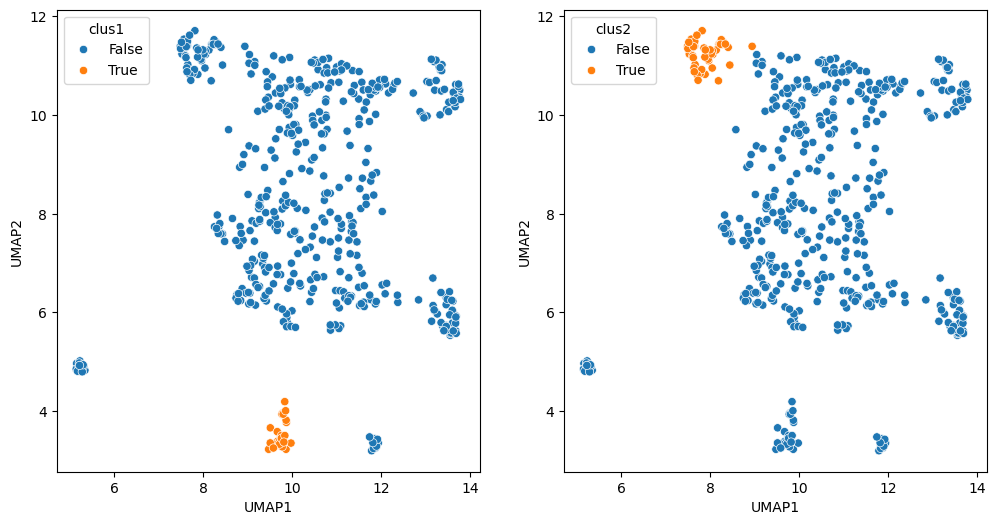

In [227]:
ures = ures.assign(clus1 = lambda x: (x.UMAP2 > 3) & (x.UMAP2 < 5) & (x.UMAP1 > 9) & (x.UMAP1 < 11)) 
ures = ures.assign(clus2 = lambda x: (x.UMAP2 > 10) & (x.UMAP2 < 12) & (x.UMAP1 > 6) & (x.UMAP1 < 9)) 

f,axes = plt.subplots(1,2, figsize=(12,6))
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='clus1', data=ures, ax=axes[0])
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='clus2', data=ures, ax=axes[1])
plt.show()

In [228]:
mut_long = pd.read_csv('/home/teddy/local/TKG-DTI/data/tkg_raw/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')
mut_long.head()

,dbgap_sample_id,capture_type,seqnames,pos_start,pos_end,ref,alt,genotyper,tumor_only,total_reads,...,cdna_position,cds_position,protein_position,amino_acids,codons,existing_variation,refseq,sift,polyphen,exac_af
0,BA2336D,NexteraV1.2,4,106156042,106156043,TC,T,varscan,1,151,...,1804/10166,944/6009,315/2002,S/X,tCc/tc,NaN,NaN,NaN,NaN,NaN
1,BA2336D,NexteraV1.2,4,106190829,106190830,AG,A,varscan,1,74,...,4968/10166,4108/6009,1370/2002,G/X,Ggg/gg,rs756348991,NaN,NaN,NaN,0.000037
2,BA2336D,NexteraV1.2,5,170837543,170837543,C,CTCTG,varscan,1,59,...,1160-1161/1758,859-860/885,287/294,L/LCX,ctc/cTCTGtc,rs758959453&COSM158604,NM_002520.6,NaN,NaN,0.000008
3,BA2643D,NexteraV1.2,11,32456651,32456652,GC,G,varscan,1,51,...,525/3122,240/1554,80/517,L/X,ctG/ct,NaN,NM_024426.4&NM_024424.3,NaN,NaN,NaN
4,BA2643D,NexteraV1.2,2,25457242,25457242,C,T,mutect,1,28,...,2983/4380,2645/2739,882/912,R/H,cGc/cAc,rs147001633&COSM52944&COSM442676,NM_175629.2,deleterious(0),probably_damaging(0.993),0.000593


In [229]:
# pivot to wide 
mut_long2 = mut_long# [lambda x: x.variant_classification.isin(['frameshift_variant', 'stop_gained'])]
mut = mut_long2.assign(mut=True)[['dbgap_sample_id', 'symbol', 'mut']].drop_duplicates().pivot(index='dbgap_sample_id', columns='symbol', values='mut').fillna(False)
mut.head()

/tmp/ipykernel_3410/1826861209.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mut = mut_long2.assign(mut=True)[['dbgap_sample_id', 'symbol', 'mut']].drop_duplicates().pivot(index='dbgap_sample_id', columns='symbol', values='mut').fillna(False)


symbol,A1CF,A2M,A4GALT,AADAC,AADACL3,AADACL4,AAK1,AARS2,AASS,AATK,...,ZNRF4,ZP3,ZP4,ZRANB1,ZRSR2,ZSCAN1,ZSCAN2,ZSWIM6,ZXDB,ZZEF1
dbgap_sample_id,,,,,,,,,,,,,,,,,,,,,
BA2000D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BA2003D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BA2004D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BA2005D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BA2006D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [230]:
ures2 = ures[lambda x: x.dbgap_dnaseq_sample.isin(mut.index)]
mut2 = mut.loc[ures2.dbgap_dnaseq_sample.values]

y1 = ures2.clus1.values
y2 = ures2.clus2.values

clus1_corrs = {'gene':[], 'r':[], 'pval':[], 'n':[]}
clus2_corrs = {'gene':[], 'r':[], 'pval':[], 'n':[]}
for gene in mut.columns: 
    x = mut2[gene].values
    r1 = spearmanr(y1, x)
    r2 = spearmanr(y2, x)
    clus1_corrs['gene'].append(gene)
    clus1_corrs['r'].append(r1.statistic)
    clus1_corrs['pval'].append(r1.pvalue)
    clus1_corrs['n'].append(x.sum())
    clus2_corrs['gene'].append(gene)
    clus2_corrs['r'].append(r2.statistic)
    clus2_corrs['pval'].append(r2.pvalue)
    clus2_corrs['n'].append(x.sum())

clus1_corrs = pd.DataFrame(clus1_corrs).fillna(1)
clus2_corrs = pd.DataFrame(clus2_corrs).fillna(1)

clus1_corrs = clus1_corrs.assign(pval_adj = multipletests(clus1_corrs.pval, method='fdr_bh')[1])
clus2_corrs = clus2_corrs.assign(pval_adj = multipletests(clus2_corrs.pval, method='fdr_bh')[1])

/tmp/ipykernel_3410/11561550.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r1 = spearmanr(y1, x)
/tmp/ipykernel_3410/11561550.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r2 = spearmanr(y2, x)


In [243]:
clus1_corrs.sort_values('pval_adj', ascending=True).head().style.hide()

gene,r,pval,n,pval_adj
CEBPA,0.707455,0.000000,34,0.000000
GATA2,0.440977,0.000000,24,0.000000
NFE2,0.297608,0.000000,6,0.000000
ZNF142,0.264748,0.000000,2,0.000004
IMPG1,0.264748,0.000000,2,0.000004


In [244]:
clus2_corrs.sort_values('pval_adj', ascending=True).head().style.hide()

gene,r,pval,n,pval_adj
NPM1,0.481437,0.000000,112,0.000000
IDH2,0.250257,0.000000,58,0.000070
TET2,0.239978,0.000000,67,0.000170
TBL1XR1,0.211398,0.000004,2,0.002706
HCN1,0.211398,0.000004,2,0.002706


In [233]:
ures3.head()

,UMAP1,UMAP2,train,gdc_id,patientId,labId,dbgap_subject_id,dbgap_rnaseq_sample,dbgap_dnaseq_sample,rna_set,...,clus1,clus2,dbgap_sample_id,CEBPA,GATA2,NPM1_y,IDH2,TET2,CEBPAorGATA2,NPM1orIDH2orTET2
0,-0.270877,5.989901,True,001454b2-aff9-4659-85a6-73fb8092589a,825,12-00294,2518,BA2751R,NaN,train,...,False,False,NaN,False,False,False,False,False,False,False
1,-0.605527,3.894652,True,002cacd9-c03b-4526-a380-0701f41c4a9e,1675,14-00488,2354,BA2405R,BA2405D,train,...,False,False,BA2405D,False,False,False,True,False,False,True
2,-5.187701,-1.323460,True,006e5777-2603-4db7-a1d6-8c8085c5e3e5,4930,18-00173,2657,BA3297R,BA3297D,train,...,False,True,BA3297D,False,False,True,True,False,False,True
3,0.347908,3.062834,True,00870f33-cab3-4c23-bd0d-8903a5a9789e,2205,15-00559,2064,BA2589R,BA2589D,train,...,False,False,BA2589D,False,True,False,True,False,True,True
4,0.782802,0.310667,True,00b535f6-064a-4dcf-ab14-387a54eedeee,4028,16-00810,2414,BA2098R,BA2098D,train,...,False,False,BA2098D,False,False,True,False,False,False,True


/tmp/ipykernel_3410/4020125993.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.CEBPA = ures3.CEBPA.fillna(False)
/tmp/ipykernel_3410/4020125993.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.GATA2 = ures3.GATA2.fillna(False)
/tmp/ipykernel_3410/4020125993.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.NPM1_

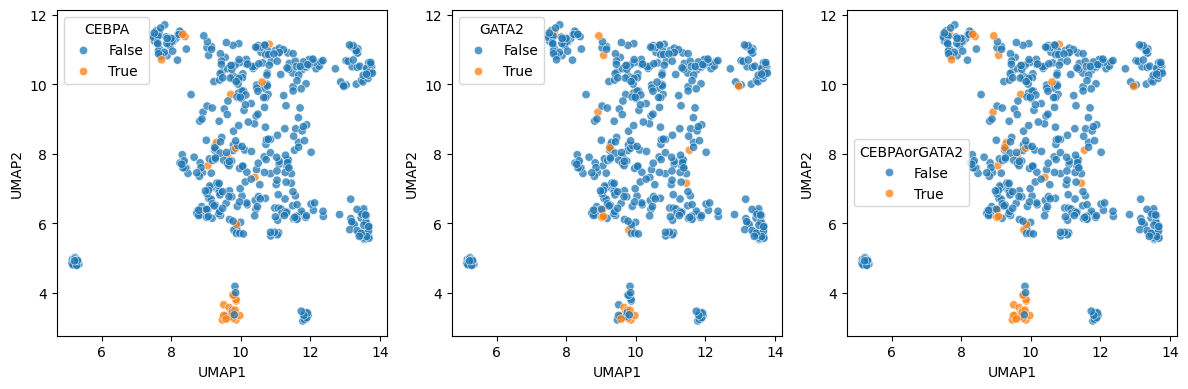

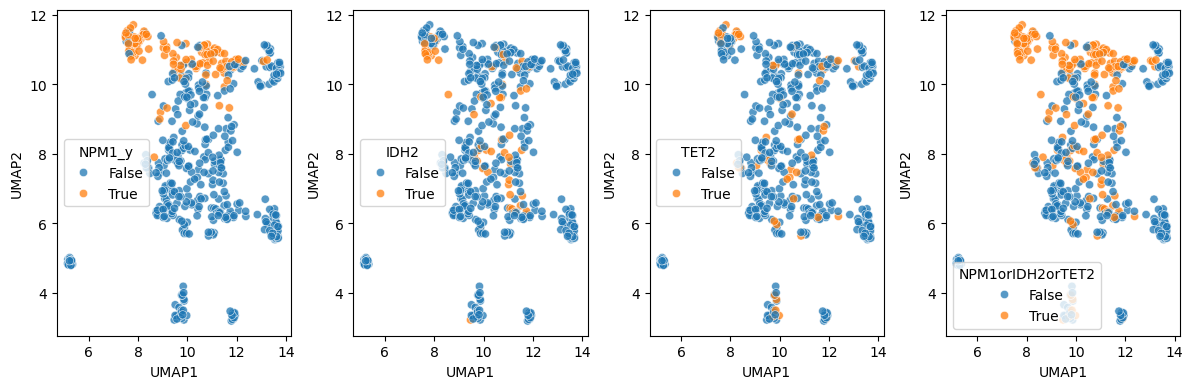

In [238]:
_alpha = 0.75

ures3 = ures.merge(mut.reset_index()[['dbgap_sample_id', 'CEBPA', 'GATA2', 'NPM1', 'IDH2', 'TET2']], left_on='dbgap_dnaseq_sample', right_on='dbgap_sample_id', how='left')
ures3.CEBPA = ures3.CEBPA.fillna(False)
ures3.GATA2 = ures3.GATA2.fillna(False)
ures3.NPM1_y = ures3.NPM1_y.fillna(False)
ures3.IDH2 = ures3.IDH2.fillna(False)
ures3.TET2 = ures3.TET2.fillna(False)
ures3 = ures3.assign(CEBPAorGATA2 = ures3.CEBPA | ures3.GATA2)
ures3 = ures3.assign(NPM1orIDH2orTET2 = ures3.NPM1_y | ures3.IDH2 | ures3.TET2)

f,axes = plt.subplots(1,3, figsize=(12,4))
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='CEBPA', data=ures3, ax=axes[0], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='GATA2', data=ures3, ax=axes[1], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='CEBPAorGATA2', data=ures3, ax=axes[2], alpha=_alpha)
plt.tight_layout()
plt.show()

f,axes = plt.subplots(1,4, figsize=(12,4))
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='NPM1_y', data=ures3, ax=axes[0], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='IDH2', data=ures3, ax=axes[1], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='TET2', data=ures3, ax=axes[2], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='NPM1orIDH2orTET2', data=ures3, ax=axes[3], alpha=_alpha)
plt.tight_layout()
plt.show()

In [25]:
clin = pd.read_csv('../../../beataml_clinical_for_inputs.csv')

: 

In [82]:
def run(gene_ixs, clin, verbose=True, num_epochs=100, batch_size=1000, lr=1e-3, return_model=False): 

    X = torch.tensor(expr.values, dtype=torch.float32)
    X = X[:, gene_ixs]
    
    torch.cuda.empty_cache()

    # Initialize model, criterion, optimizer, and device
    input_dim = X.shape[1]
    hidden_dims = [1012, 512]
    latent_dim = 124
    model = VAE(input_dim, hidden_dims, latent_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    crit = loss_function
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='max', factor=0.5, patience=1000, threshold=1e-3)

    # Split data into training and validation sets
    num_samples = X.size(0)
    num_train = int(0.9 * num_samples)
    train_data, val_data = torch.utils.data.random_split(X, [num_train, num_samples - num_train])

    best_state = None 
    best_loss = np.inf

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        jj = 0
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size].to(device)
            optim.zero_grad()
            recon_x,  mu, logvar = model(batch)
            loss = crit(batch, recon_x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optim.step()
            jj += 1

        # Validation
        model.eval()
        val_loss = 0
        r2_total = 0
        kk = 0
        with torch.no_grad():
            for i in range(0, len(val_data), batch_size):
                batch = val_data[i:i+batch_size].to(device)
                recon_batch, mu, logvar = model(batch)
                mse = F.mse_loss(recon_batch, batch, reduction='mean')
                r2 = r2_score(batch.cpu().numpy(), recon_batch.cpu().numpy(), multioutput='uniform_average')
                r = np.mean([np.corrcoef(batch[i].cpu().numpy(), recon_batch[i].cpu().numpy())[0, 1] for i in range(batch.size(0))])
                val_loss += loss.item()
                r2_total += r2
                kk += 1
                val_loss = crit(batch, recon_batch, mu, logvar)

        avg_loss = val_loss / kk
        r2_avg = r2_total / kk
        r_avg = r / kk
        scheduler.step(r2_avg)
        lr = scheduler.get_last_lr()[0]

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()

        if verbose: print(f'Epoch {epoch+1}, Train Loss: {train_loss/jj:.4f}, Val Loss: {val_loss/kk:.4f}, val MSE: {mse:.3f}, val R2: {r2_avg:.3f} -> lr: {lr:.2E}', end='\r')

    model.load_state_dict(best_state)

    z = model.cpu().encode(X)[0].detach().numpy()

    clin = clin.set_index('gdc_id')

    labels = clin.loc[expr.index]['consensusAMLFusions'].values

    # convert labels from string to integer 
    labels = pd.Categorical(labels).codes

    idxs = labels != -1
    labels = labels[idxs]
    z = z[idxs]

    if return_model: 
        return model 
    else: 
        return silhouette_score(z, labels)

: 

In [ ]:
run((sd.values > np.quantile(sd, 0.95)).nonzero()[0], clin, verbose=True, num_epochs=100, batch_size=1000, lr=1e-3)

0.15649801

: 

In [ ]:
#theta = torch.nn.Parameter(torch.zeros(expr.shape[1], dtype=torch.float32), requires_grad=True)
#init_val = (sd.values - sd.values.mean())/sd.values.std()
# theta = torch.nn.Parameter(torch.tensor(init_val, dtype=torch.float32), requires_grad=True)

high_var_idxs = np.where(sd.values > np.quantile(sd, 0.75))[0]
n_high_var = len(high_var_idxs)
theta = torch.nn.Parameter(torch.zeros(n_high_var, dtype=torch.float32), requires_grad=True)

opt = torch.optim.Adam([theta], lr=1e-1)

rewards = [] 
for i in range(2500): 

    m = torch.distributions.Bernoulli(logits=theta)
    action = m.sample()
    ixs = torch.where(action == 1)[0].numpy()
    gene_ixs = high_var_idxs[ixs]

    reward = run(gene_ixs, clin, verbose=False, num_epochs=150)
    reward = np.clip(reward, -1, 1)
    rewards.append(reward)
    d = np.mean(rewards[-10:])
    adv = (reward - d)/(np.std(rewards[-10:]) + 1e-8)

    opt.zero_grad()

    loss = -m.log_prob(action).mean() * adv
    loss.backward()
    opt.step()

    print(f'iter: {i} ||>>|| reward: {reward:.3f} || advantage: {adv.item():.3f} || d: {d:.3f} || n actions: {action.sum().item()}')

iter: 0 ||>>|| reward: 0.134 || advantage: 0.000 || d: 0.134 || n actions: 2494.0
iter: 1 ||>>|| reward: 0.132 || advantage: -1.000 || d: 0.133 || n actions: 2535.0
iter: 2 ||>>|| reward: 0.134 || advantage: 0.652 || d: 0.133 || n actions: 2495.0
iter: 3 ||>>|| reward: 0.132 || advantage: -1.172 || d: 0.133 || n actions: 2511.0
iter: 4 ||>>|| reward: 0.129 || advantage: -1.692 || d: 0.132 || n actions: 2474.0
iter: 5 ||>>|| reward: 0.128 || advantage: -1.580 || d: 0.131 || n actions: 2476.0
iter: 6 ||>>|| reward: 0.137 || advantage: 1.599 || d: 0.132 || n actions: 2465.0
iter: 7 ||>>|| reward: 0.126 || advantage: -1.608 || d: 0.131 || n actions: 2513.0
iter: 8 ||>>|| reward: 0.133 || advantage: 0.531 || d: 0.132 || n actions: 2455.0
iter: 9 ||>>|| reward: 0.136 || advantage: 1.135 || d: 0.132 || n actions: 2443.0
iter: 10 ||>>|| reward: 0.130 || advantage: -0.588 || d: 0.132 || n actions: 2555.0
iter: 11 ||>>|| reward: 0.117 || advantage: -2.382 || d: 0.130 || n actions: 2477.0
iter: 1

: 

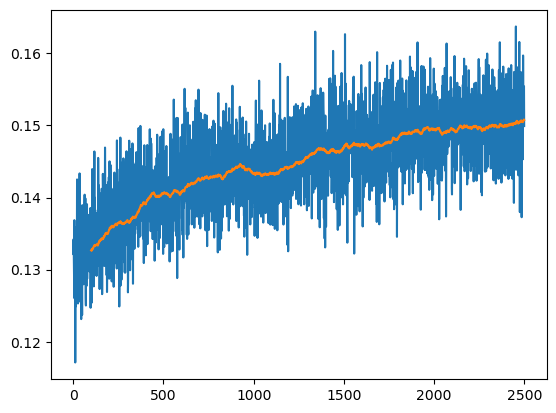

: 

In [125]:
plt.figure()
plt.plot(rewards)
# plot average reward over last 10 iterations
plt.plot(pd.Series(rewards).rolling(100).mean().values)
plt.show()

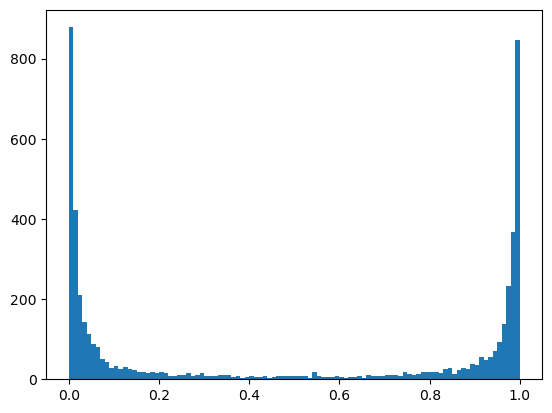

: 

In [126]:
plt.figure()
plt.hist(theta.sigmoid().detach().numpy(), bins=100)
plt.show()

0.032463017849151586


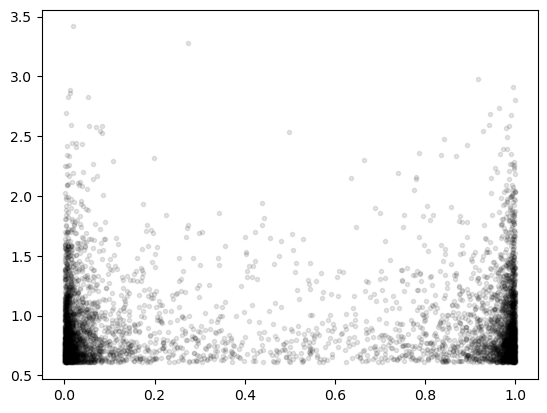

: 

In [ ]:
print(np.corrcoef(theta.sigmoid().detach().cpu().numpy(), sd.values[high_var_idxs])[0,1])

plt.figure()
plt.plot(theta.sigmoid().detach().cpu().numpy(), sd.values[high_var_idxs], 'k.', alpha=0.1)
plt.show()

: 

In [128]:
gene_ixs = high_var_idxs[(theta.sigmoid().detach().numpy() > 0.5).nonzero()[0]]

model = run(gene_ixs, clin, verbose=True, num_epochs=200, batch_size=1000, lr=1e-3, return_model=True)

: 

In [56]:
#X = torch.tensor(expr.values, dtype=torch.float32)
#z = model.cpu().encode(X[:, gene_ixs])[0].detach().numpy()

#X = torch.tensor(expr.values, dtype=torch.float32)
# get top 2000 most variable genes 
#top_2k_idxs = np.sort( np.argsort(sd.values)[::-1][:2000] ) 
#z = X[:, top_2k_idxs] 
model = trainer.get_best_model()
z = model.encode(X)[0].detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
u = reducer.fit_transform(z)

ures = pd.DataFrame(u, columns=['UMAP1', 'UMAP2']).assign(gdc_id=expr.index)
ures = ures.merge(clin, on='gdc_id')
ures = ures.fillna('none')
ures.head()


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,UMAP1,UMAP2,gdc_id,patientId,labId,dbgap_subject_id,dbgap_rnaseq_sample,dbgap_dnaseq_sample,rna_set,dna_set,...,dxAtSpecimenAcquisition,isTransformed,priorMDS,FLT3-ITD,allelic_ratio,NPM1,RUNX1,ASXL1,TP53,ELN2017
0,0.723483,1.002065,001454b2-aff9-4659-85a6-73fb8092589a,825,12-00294,2518,BA2751R,none,train,none,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,positive,1.0,negative,none,none,none,Adverse
1,0.536965,2.727864,002cacd9-c03b-4526-a380-0701f41c4a9e,1675,14-00488,2354,BA2405R,BA2405D,train,train,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,positive,0.449275,negative,RUNX1 (p.Q262*; 72.4%),none,none,Adverse
2,-0.823124,6.581014,006e5777-2603-4db7-a1d6-8c8085c5e3e5,4930,18-00173,2657,BA3297R,BA3297D,train,train,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.0,positive,none,none,none,Favorable
3,-0.355028,2.363687,00870f33-cab3-4c23-bd0d-8903a5a9789e,2205,15-00559,2064,BA2589R,BA2589D,train,train,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.0,negative,none,none,none,NonInitial
4,-1.864946,2.751128,00b535f6-064a-4dcf-ab14-387a54eedeee,4028,16-00810,2414,BA2098R,BA2098D,train,train,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.0,positive,none,none,none,Favorable


: 

In [57]:
ures.columns

Index(['UMAP1', 'UMAP2', 'gdc_id', 'patientId', 'labId', 'dbgap_subject_id',
       'dbgap_rnaseq_sample', 'dbgap_dnaseq_sample', 'rna_set', 'dna_set',
       'cohort', 'manuscript_rnaseq', 'manuscript_dnaseq', 'consensus_sex',
       'reportedRace', 'reportedEthnicity', 'specimenType', 'isDenovo',
       'ageAtDiagnosis', 'consensusAMLFusions', '%.Blasts.in.BM',
       '%.Blasts.in.PB', 'vitalStatus', 'overallSurvival',
       'diseaseStageAtSpecimenCollection', 'specimenGroups',
       'dxAtSpecimenAcquisition', 'isTransformed', 'priorMDS', 'FLT3-ITD',
       'allelic_ratio', 'NPM1', 'RUNX1', 'ASXL1', 'TP53', 'ELN2017'],
      dtype='object')

: 

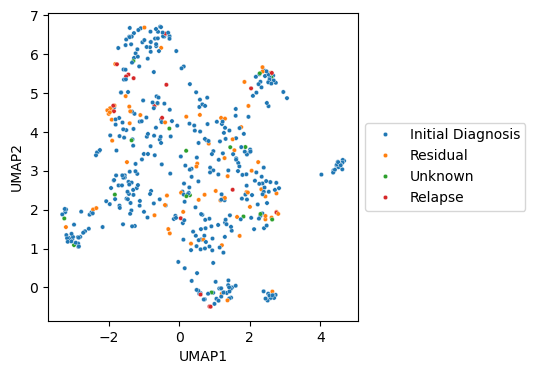

: 

In [58]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='diseaseStageAtSpecimenCollection', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

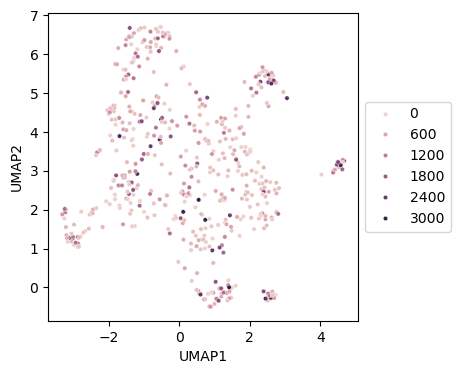

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='overallSurvival', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

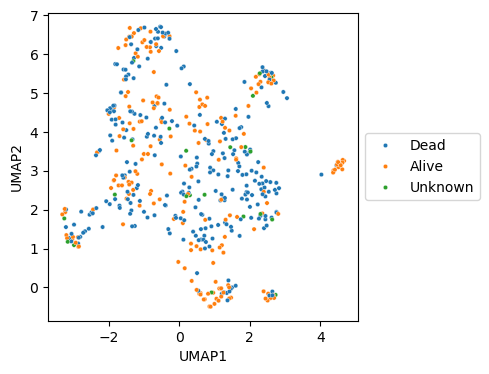

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='vitalStatus', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

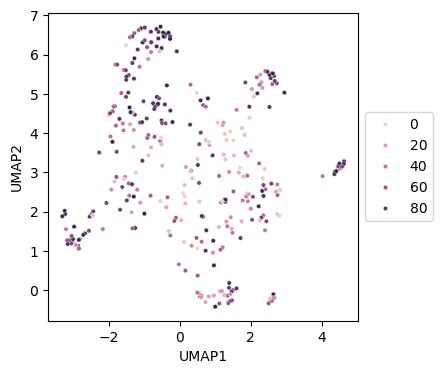

: 

In [ ]:
ures['%.Blasts.in.PB'] = pd.to_numeric(ures['%.Blasts.in.PB'], errors='coerce')
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: ~x['%.Blasts.in.PB'].isna()], x='UMAP1', y='UMAP2', hue='%.Blasts.in.PB', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

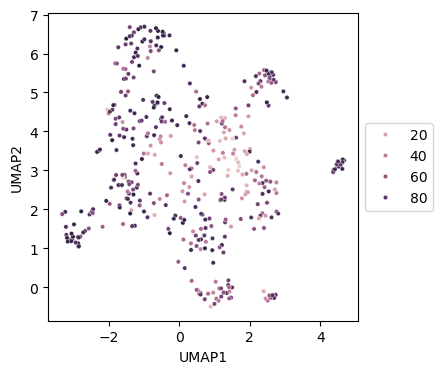

: 

In [62]:
ures['%.Blasts.in.BM'] = pd.to_numeric(ures['%.Blasts.in.BM'], errors='coerce')
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: ~x['%.Blasts.in.BM'].isna()], x='UMAP1', y='UMAP2', hue='%.Blasts.in.BM', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


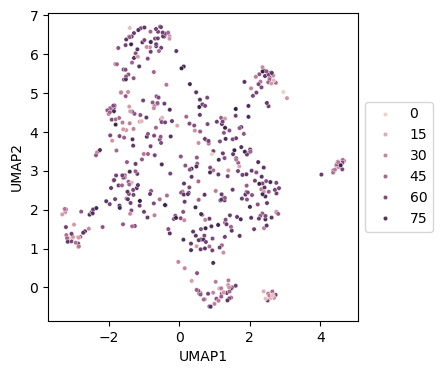

: 

In [63]:
#ures['ageAtDiagnosis'] = ures['ageAtDiagnosis'].astype(float)
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: x.ageAtDiagnosis != 'none'], x='UMAP1', y='UMAP2', hue='ageAtDiagnosis', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

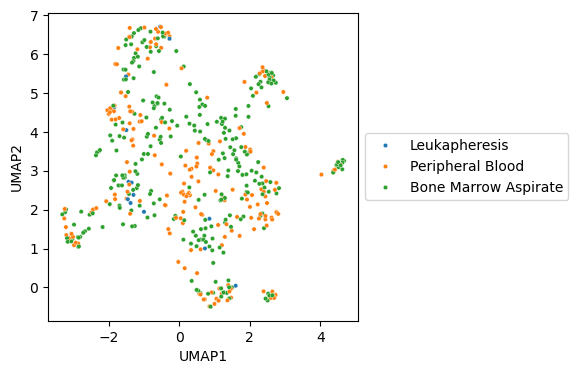

: 

In [64]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='specimenType', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

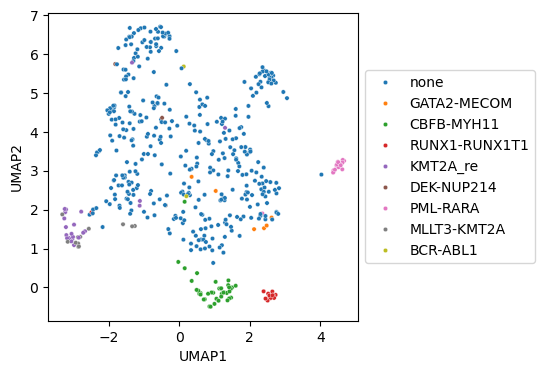

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensusAMLFusions', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [ ]:
clin = clin.set_index('gdc_id')
labels = clin.loc[expr.index]['consensusAMLFusions'].values

# convert labels from string to integer 
labels = pd.Categorical(labels).codes

idxs = labels != -1
labels = labels[idxs]
z = z[idxs]

silhouette_score(z, labels)

KeyError: "None of ['gdc_id'] are in the columns"

: 

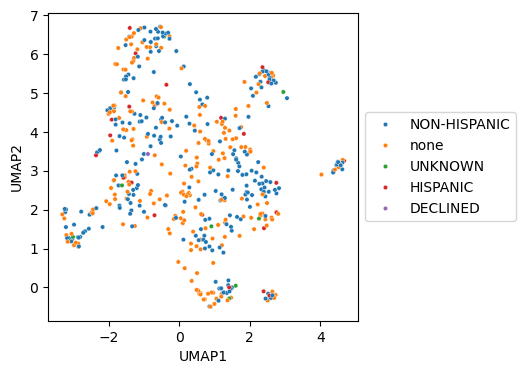

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedEthnicity', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

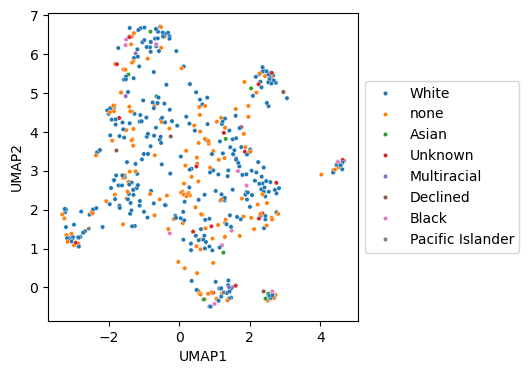

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedRace', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

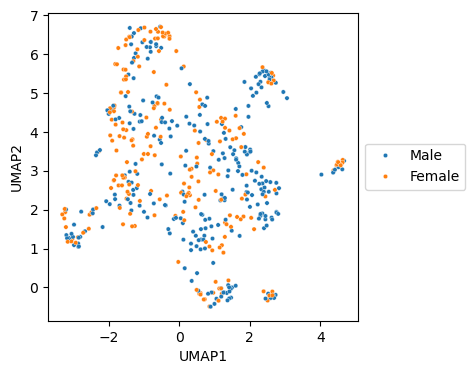

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensus_sex', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

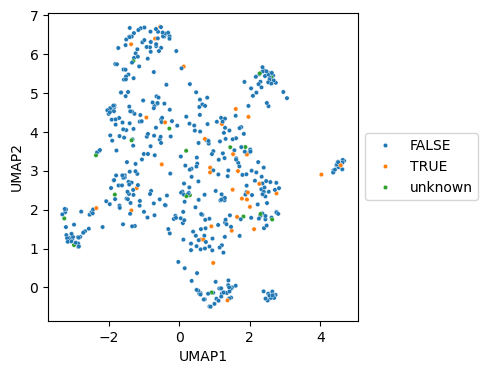

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='isTransformed', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(9, 4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='FLT3-ITD', s=10, ax=axes[0])
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='NPM1', s=10, ax=axes[1])
plt.tight_layout()
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe07d32340>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^

: 

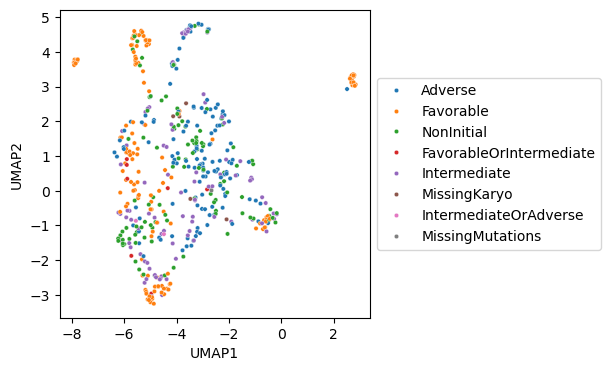

: 

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='ELN2017', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

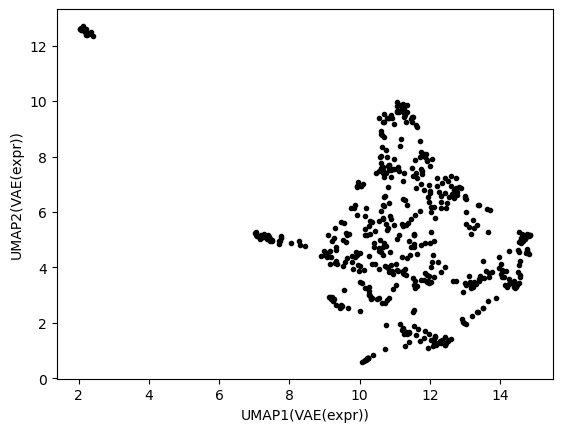

: 

: 

In [ ]:
plt.figure() 
plt.plot(u[:, 0], u[:, 1], 'k.')
plt.xlabel('UMAP1(VAE(expr))')
plt.ylabel('UMAP2(VAE(expr))') 
plt.show()

: 

In [11]:
expr.shape

(511, 19938)

: 

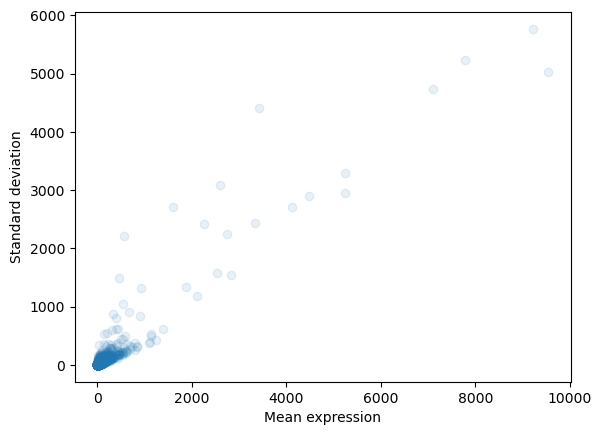

: 

In [16]:
gene_stds = expr.std(axis=0)
gene_means = expr.mean(axis=0)
plt.figure() 
plt.scatter(gene_means, gene_stds, alpha=0.1)
plt.xlabel('Mean expression')
plt.ylabel('Standard deviation')
plt.show()


: 

In [3]:
expr.gene_id.nunique()

60660

: 

In [4]:
expr.gene_name.nunique()

59427

: 

In [5]:
expr.id.nunique()

511

: 

In [6]:
expr.groupby('gene_type').count()[['gene_id']]

,gene_id
gene_type,
IG_C_gene,7154
IG_C_pseudogene,4599
IG_D_gene,18907
IG_J_gene,9198
IG_J_pseudogene,1533
IG_V_gene,74095
IG_V_pseudogene,95557
IG_pseudogene,511
Mt_rRNA,1022


: 

: 